# Project 1: MTA Data Visualization for WTWY

by Andrew Zhou, Srividya Sistla, and Albert Lee

## The Task at Hand

We're a data science analytics firm that has been approached by WTWY (Woman Tech Woman Yes) to give them recommendations for where to collect signatures and contact information from potential attendees of and donors to their annual gala. They plan to position teams at MTA subway stations to take advantage of commuter traffic, and those who sign up for their email list will receive tickets to the gala. WTWY would then like to solicit donations from these individuals. They would like recommendations to optimize the placement of their street teams.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Data Sourcing and Cleaning

### Data Source and Initial Cleaning

We use Vinny's partially-cleaned data while conducting further cleaning and grouping. The data are from the MTA, and we look at 3 consecutive weeks from 8/27/16 to 9/16/16.

In [2]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "data/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [160903, 160910, 160917]
turnstiles_df = get_data(week_nums)

In [3]:
turnstiles_df.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,00:00:00,REGULAR,5799442,1966041
1,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,04:00:00,REGULAR,5799463,1966044
2,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,08:00:00,REGULAR,5799492,1966079
3,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,12:00:00,REGULAR,5799610,1966155
4,A002,R051,02-00-00,59 ST,NQR456,BMT,08/27/2016,16:00:00,REGULAR,5799833,1966214


### Removing Irregular Times

We're interested in cleaning the timeslot data. Let's take a look at how the entries are distributed.

In [4]:
# Print the unique timefields; count the ones that aren't on the hour (minutes & seconds aren't 00:00)
print(turnstiles_df["TIME"].unique())
len(turnstiles_df["TIME"].unique())

['00:00:00' '04:00:00' '08:00:00' ... '12:41:15' '12:42:39' '11:57:55']


20813

In [5]:
# That's a lot of different times. Let's see how many aren't on the hour 
odd_times = len(turnstiles_df[[time[3:] != "00:00" for time in turnstiles_df["TIME"]]])
total_times = len(turnstiles_df)
odd_times, total_times, odd_times/total_times

(46559, 580895, 0.08015045748371048)

~8% of the data are at irregular times. This proportion is fairly low, especially as the entries column tracks a rolling counter. Thus, getting rid of these data seems unlikely to influence our results substantially if the regular entries are correct.

In [6]:
# Drop irregular times
turnstiles_df = turnstiles_df[[time[3:5] == "00" and time[6:] == "00" for time in turnstiles_df["TIME"]]]

# What's left?
turnstiles_df["TIME"].value_counts()

08:00:00    50661
00:00:00    50660
04:00:00    50655
20:00:00    50616
12:00:00    50610
16:00:00    50594
01:00:00    35365
05:00:00    35331
13:00:00    35323
09:00:00    35315
21:00:00    35295
17:00:00    35285
18:00:00     2288
22:00:00     2288
06:00:00     2287
02:00:00     2287
14:00:00     2287
10:00:00     2274
15:00:00      820
19:00:00      819
11:00:00      819
23:00:00      819
03:00:00      819
07:00:00      819
Name: TIME, dtype: int64

### Synchronizing Time Cycles

We see that there seem to be different cycles: 12AM/4AM/8AM/12PM/4PM/8PM, 1AM/5AM/9AM/1PM/5PM/9PM, etc.

We might like to shift everything to the 12AM, 4AM, 8AM, 12PM, 4PM, 8PM cycle in order to simplify our analysis. But we need to check that there are no merging conflicts, e.g. a day with entries that belong to multiple cycles. In that case, we might shift a 9AM entry to 8AM while an 8AM entry already exists.

In [7]:
# Detect a conflict in a series of times for a particular turnstile on a particular date
def conflict_exists(times):
    to_hours = list(map(lambda x: int(x[:2]), times))
    return len(np.unique(np.array(to_hours) % 4)) != 1

# Check for conflicts
(turnstiles_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"]))["TIME"] \
        .agg(lambda x: len(np.unique((np.array(list(map(lambda y: int(y[:2]), x))) % 4))) != 1).sum()

0

No conflicts, so we establish 12AM/4AM/8AM/12PM/4PM/8PM as our desired cycle and shift all other cycles back to match.

In [8]:
# shift %H:00:00 to the previous multiple of 4, e.g. 5AM, 6AM, 7AM to 4AM
def shift_time(time_str):
    hour = int(time_str[:2])
    hour -= hour % 4
    return str(hour).zfill(2) + time_str[2:]

turnstiles_df["TIME"] = turnstiles_df["TIME"].apply(lambda x: shift_time(x))
turnstiles_df["TIME"].value_counts()

00:00:00    89131
04:00:00    89092
08:00:00    89069
12:00:00    89040
20:00:00    89018
16:00:00    88986
Name: TIME, dtype: int64

As desired, we've shifted all the times.

In [9]:
# We add a column of datetime objects
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df["DATE"] + " " + turnstiles_df["TIME"], 
                                                format="%m/%d/%Y %H:%M:%S")

In [10]:
# Let's check for conflicts
(turnstiles_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"],as_index=False)
                        .ENTRIES.count().sort_values(by="ENTRIES", ascending=False).head(5))


,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
467843,R504,R276,00-00-01,VERNON-JACKSON,2016-09-16 08:00:00,2
0,A002,R051,02-00-00,59 ST,2016-08-27 00:00:00,1
356233,R165,R167,01-00-02,86 ST,2016-09-12 12:00:00,1
356231,R165,R167,01-00-02,86 ST,2016-09-12 04:00:00,1
356230,R165,R167,01-00-02,86 ST,2016-09-12 00:00:00,1


Only one duplicate entry (the one Vinny isolated). Let's remove all duplicates using his method.

In [11]:
# Get rid of the duplicate entry
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

(turnstiles_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"],as_index=False)
                        .ENTRIES.count().sort_values(by="ENTRIES", ascending=False).head(5))

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2016-08-27 00:00:00,1
356234,R165,R167,01-00-02,86 ST,2016-09-12 16:00:00,1
356232,R165,R167,01-00-02,86 ST,2016-09-12 08:00:00,1
356231,R165,R167,01-00-02,86 ST,2016-09-12 04:00:00,1
356230,R165,R167,01-00-02,86 ST,2016-09-12 00:00:00,1


It's gone, as desired.

### Calculating Entries In Each Timeslot

Now let's create a new DataFrame with one row per turnstile/date-time. We would like to compute the difference between the entries and the entries shifted by one row.

Note that we'd like our entry for, say, 4AM on a particular day to indicate the number of entries in the 4AM-8AM time period.

In [12]:
turnstiles_by_timeslot = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME", "DATE", "TIME"],as_index=False)
                        .ENTRIES.first())

turnstiles_by_timeslot[["NEXT_TIME", "NEXT_ENTRIES"]] = turnstiles_by_timeslot.groupby(["C/A", "UNIT", "SCP", "STATION"])\
                                                                    [["DATE_TIME", "ENTRIES"]]\
                                                                    .apply(lambda grp: grp.shift(-1))
# Let's drop the last point for which there's no subsequent entry data
turnstiles_by_timeslot.dropna(subset=["NEXT_TIME"], axis=0, inplace=True)

In [13]:
# Let's do another check: we want DATE_TIME and NEXT_TIME to be either the same or consecutive so we don't
# get inaccurate counts for late-night entries. 
date_diffs = turnstiles_by_timeslot["NEXT_TIME"].map(lambda x: x.date()) - turnstiles_by_timeslot["DATE_TIME"].map(lambda x: x.date())
date_diffs.value_counts()

0 days     445087
1 days      84971
2 days         16
3 days          4
5 days          1
11 days         1
dtype: int64

So there's a handful of data points where the next day doesn't immediately follow. Let's just set ENTRIES and NEXT_ENTRIES for these rows to zero so the entries will be counted as zero for those timeslots.

In [14]:
date_error = date_diffs > pd.Timedelta(1, unit="day")
turnstiles_by_timeslot.loc[date_error, ["ENTRIES", "NEXT_ENTRIES"]] = [0,0]

We use Vinny's counting function on our data. We set a large `max_counter` first so we can examine the distribution of outliers.

In [15]:
def get_counts(row, max_counter):
    counter = row["NEXT_ENTRIES"] - row["ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        #print(row["ENTRIES"], row["NEXT_ENTRIES"])
        return 0
    return counter

turnstiles_by_timeslot["NUM_ENTRIES"] = turnstiles_by_timeslot.apply(get_counts, axis=1, max_counter=100000)

Let's take a look at the distribution of entry numbers.

In [16]:
turnstiles_by_timeslot["NUM_ENTRIES"].groupby(pd.cut(turnstiles_by_timeslot["NUM_ENTRIES"], [0,1000,1500, 2000,2500,3000,4000,10000,30000,100000])).count()

NUM_ENTRIES
(0, 1000]          451990
(1000, 1500]         7678
(1500, 2000]         1831
(2000, 2500]          412
(2500, 3000]          103
(3000, 4000]           11
(4000, 10000]           1
(10000, 30000]          6
(30000, 100000]         5
Name: NUM_ENTRIES, dtype: int64

Looks like anything above 3000 may be suspicious, so let's remove any that are obviously incorrect.

### Dropping Spurious Entry Data

In [17]:
turnstiles_by_timeslot[turnstiles_by_timeslot["NUM_ENTRIES"] > 3000][["ENTRIES", "NEXT_ENTRIES", "NUM_ENTRIES"]].sort_values(by="NUM_ENTRIES")

,ENTRIES,NEXT_ENTRIES,NUM_ENTRIES
162532,8528768,8531772.0,3004.0
402323,7476109,7479130.0,3021.0
405199,32593208,32596230.0,3022.0
140384,8009336,8012363.0,3027.0
162538,8537928,8540990.0,3062.0
402329,7484705,7487820.0,3115.0
140378,8000798,8003965.0,3167.0
402365,7532198,7535405.0,3207.0
402371,7541659,7544911.0,3252.0
402377,7551515,7554796.0,3281.0


Looks like anything over 4000 is due to the counter resetting. Let's get rid of them. Let's also toss the counter columns and the next timeslot.

In [18]:
turnstiles_by_timeslot.loc[turnstiles_by_timeslot["NUM_ENTRIES"] > 4000, "NUM_ENTRIES"] = 0
turnstiles_by_timeslot.drop(axis=1, labels=["ENTRIES", "NEXT_ENTRIES", "NEXT_TIME"], inplace=True)

The data are clean! Let's take a look at what's going on.

## Data Exploration and Analysis

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Now we're ready to figure out which stations are highly trafficked, and on which dates and times. First, here's our cleaned dataset.

In [20]:
turnstiles_by_timeslot.head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,DATE,TIME,NUM_ENTRIES
0,A002,R051,02-00-00,59 ST,2016-08-27 00:00:00,08/27/2016,00:00:00,21.0
1,A002,R051,02-00-00,59 ST,2016-08-27 04:00:00,08/27/2016,04:00:00,29.0
2,A002,R051,02-00-00,59 ST,2016-08-27 08:00:00,08/27/2016,08:00:00,118.0
3,A002,R051,02-00-00,59 ST,2016-08-27 12:00:00,08/27/2016,12:00:00,223.0
4,A002,R051,02-00-00,59 ST,2016-08-27 16:00:00,08/27/2016,16:00:00,288.0


### Traffic by Day of Week

Let's see how traffic through the entire subway system varies by the day of the week. Is it worth it to collect signatures on weekends? 

In [21]:
# Add a column for the day of the week, where 0 is Monday, 1 is Tuesday, etc.
turnstiles_by_timeslot["DOW_INDEX"] = turnstiles_by_timeslot["DATE_TIME"].apply(lambda x: x.weekday())

# Sum traffic over each date, then group by day of week and take the mean of entries
all_traffic_by_date = turnstiles_by_timeslot.groupby(["DATE", "DOW_INDEX"])["NUM_ENTRIES"].sum()
mean_daily_traffic = all_traffic_by_date.groupby(["DOW_INDEX"]).mean()
mean_daily_traffic

DOW_INDEX
0    4.398648e+06
1    5.571134e+06
2    5.700208e+06
3    5.782688e+06
4    5.456813e+06
5    3.195508e+06
6    2.619233e+06
Name: NUM_ENTRIES, dtype: float64

Weekends don't seem so great. Let's visualize it:

#### Plot

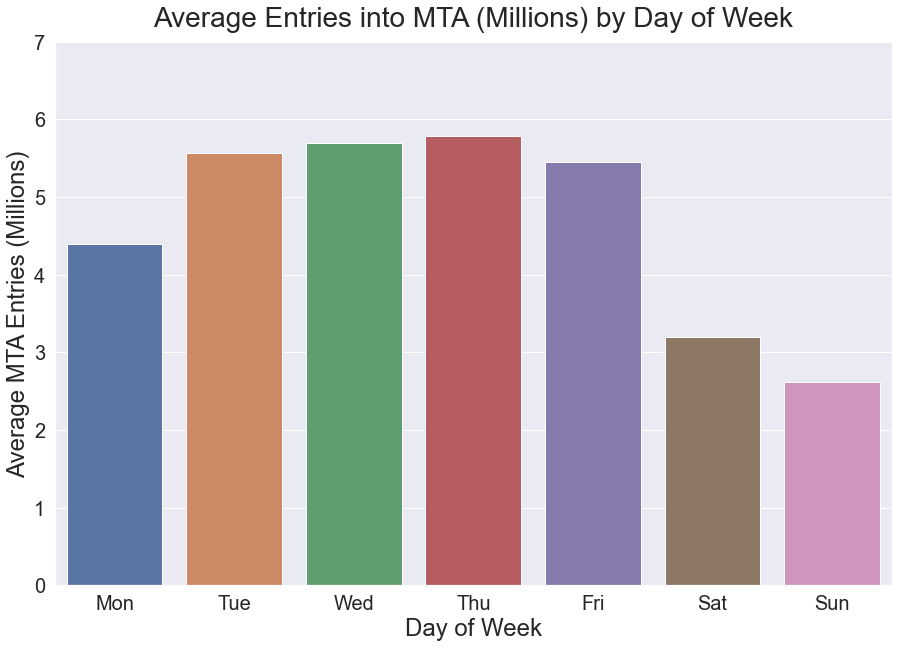

In [22]:
sns.set(rc={'figure.figsize':(15,10)})

ax = sns.barplot(x=mean_daily_traffic.index, y=mean_daily_traffic)
sns.set_style("dark")
ax.set(ylim=(0, 7000000))

ax.set_title("Average Entries into MTA (Millions) by Day of Week", fontsize=28, pad=15)
ax.set_xlabel("Day of Week", fontsize = 24)
ax.set_ylabel("Average MTA Entries (Millions)", fontsize=24)

ax.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"], fontsize=20)

ax.yaxis.set_ticks(np.arange(0,7000000 + 1,1000000))
ax.set_yticklabels([0, 1, 2, 3, 4, 5, 6, 7], fontsize=20);

The lower traffic on weekends, combined with the fact that people traveling in New York on weekends may be more likely to be visitors, suggests that weekends would be less fruitful for WTWY's signature-gathering efforts. Let's drop the weekend data. Additionally, let's group by station as we're suggesting stations rather than turnstiles.

In [23]:
stations_by_timeslot = (turnstiles_by_timeslot.groupby(['STATION','DATE_TIME', 'DATE', 'TIME', 'DOW_INDEX'])['NUM_ENTRIES'].sum()
                 .reset_index())
stations_by_timeslot_weekdays = stations_by_timeslot[stations_by_timeslot['DOW_INDEX'] < 5]

### Traffic by Timeslot

Now let's see whether it's worth it to focus on or drop any timeslots.

#### Plot

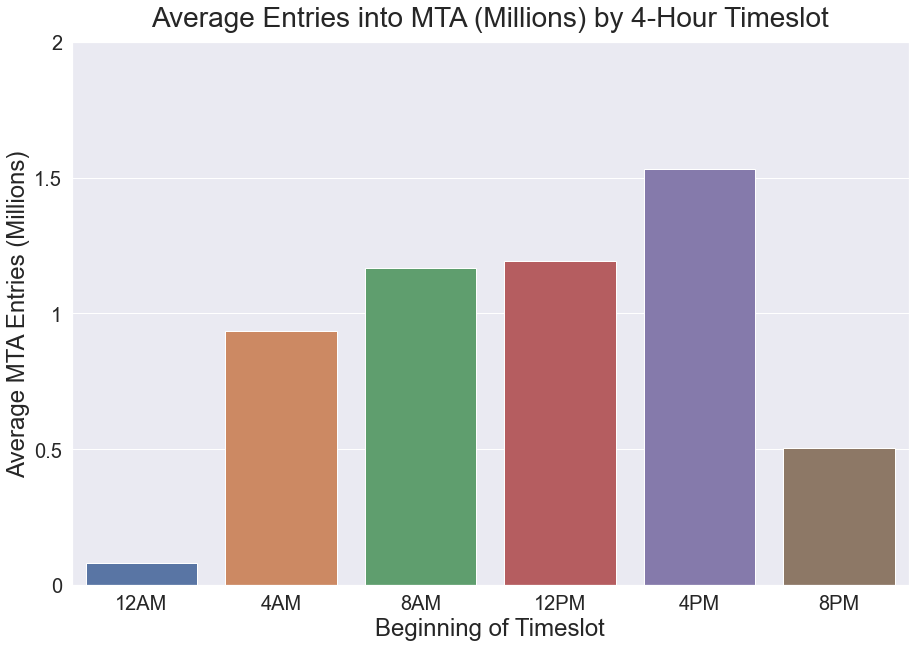

In [24]:
all_weekday_traffic_by_timeslot = stations_by_timeslot_weekdays.groupby(["TIME", "DATE"])["NUM_ENTRIES"]\
                                    .sum().groupby("TIME").mean()
sns.set_style("dark")
sns.set(rc={'figure.figsize':(15,10)})

ax = sns.barplot(x=all_weekday_traffic_by_timeslot.index, y=all_weekday_traffic_by_timeslot)
ax.set(ylim=(0, 2000000))

ax.set_title("Average Entries into MTA (Millions) by 4-Hour Timeslot", fontsize=28, pad=15)
ax.set_xlabel("Beginning of Timeslot", fontsize = 24)
ax.set_ylabel("Average MTA Entries (Millions)", fontsize=24)

ax.set_xticklabels(["12AM", "4AM", "8AM", "12PM", "4PM", "8PM"], fontsize=20)

ax.yaxis.set_ticks(np.arange(0,2000000 + 1,500000))
ax.set_yticklabels([0, 0.5, 1, 1.5, 2], fontsize=20);

The 12-4AM and 8PM-12AM timeslots are significantly less trafficked than the others. Let's ignore those.

### Traffic Patterns for Individual Stations

Let's take a look at a few of the most populated stations to see how their traffic trends over time. Are there different "types" of stations with their own traffic patterns?

In [25]:
stations_by_timeslot_mean = stations_by_timeslot_weekdays.groupby(["STATION", "TIME"])["NUM_ENTRIES"].mean().reset_index()
top_stations_morning = stations_by_timeslot_mean[stations_by_timeslot_mean["TIME"] == "04:00:00"]\
                            .sort_values(by="NUM_ENTRIES", ascending=False).head(5)
top_stations_morning

,STATION,TIME,NUM_ENTRIES
349,34 ST-PENN STA,04:00:00,35975.000000
391,42 ST-PORT AUTH,04:00:00,18560.866667
1345,GRD CNTRL-42 ST,04:00:00,15554.200000
661,96 ST,04:00:00,14326.000000
55,125 ST,04:00:00,12990.000000


In [26]:
top_stations_afternoon = stations_by_timeslot_mean[stations_by_timeslot_mean["TIME"] == "16:00:00"]\
                            .sort_values(by="NUM_ENTRIES", ascending=False).head(5)
top_stations_afternoon

,STATION,TIME,NUM_ENTRIES
1348,GRD CNTRL-42 ST,16:00:00,60345.266667
262,23 ST,16:00:00,48860.866667
340,34 ST-HERALD SQ,16:00:00,47390.333333
352,34 ST-PENN STA,16:00:00,41267.666667
1984,TIMES SQ-42 ST,16:00:00,38223.600000


Despite some overlap, we see that the most popular stations differ for morning and afternoon. (And presumably for the 8AM and 12PM timeslots as well.) We would like to tailor our strategy to the timeslot, then. For further precision, we can calculate the average traffic for each station for each particular day of week, timeslot combination.

We would like to plot station traffic over time, but want to drop data for the 12AM and 8PM timeslots. Note that when we plot the traffic versus time, we would have gaps if we spaced the x-axis linearly with respect to time. Our graph will be more legible if we omit the dropped timeslots.

Thus we define a custom scale DOW_TIME for the x-axis. The day of week is denoted by the integer portion of the value, with 0 representing Monday and 4 representing Friday. The time is denoted by the decimal portion, with 0.0 mapped to 4AM, 0.25 to 8AM, 0.5 to 12PM, and 0.75 to 4PM.

In [27]:
# Create a new dataframe for ease of use; DOW_TIME isn't defined for the 12AM and 8PM timeslots.
stations_by_date_time = pd.DataFrame(stations_by_timeslot_weekdays[(stations_by_timeslot_weekdays["TIME"] != "00:00:00") \
                                        & (stations_by_timeslot_weekdays["TIME"] != "20:00:00")])

def datetime_to_dow_time(date_time):
    return date_time.dayofweek + (date_time.hour-4)/16

stations_by_date_time["DOW_TIME"] = stations_by_date_time["DATE_TIME"].apply(datetime_to_dow_time)
stations_by_dow_time_mean = stations_by_date_time.groupby(["STATION", "DOW_TIME", "DOW_INDEX", "TIME"])["NUM_ENTRIES"].mean()

Let's select a few "morning" stations and "afternoon" stations to compare and contrast.

In [28]:
top_stations_morning.head(2), top_stations_afternoon.head(2)

(             STATION      TIME   NUM_ENTRIES
 349   34 ST-PENN STA  04:00:00  35975.000000
 391  42 ST-PORT AUTH  04:00:00  18560.866667,
               STATION      TIME   NUM_ENTRIES
 1348  GRD CNTRL-42 ST  16:00:00  60345.266667
 262             23 ST  16:00:00  48860.866667)

Grab the top two for each, then plot their entries versus day of week and timeslot.

#### Plot

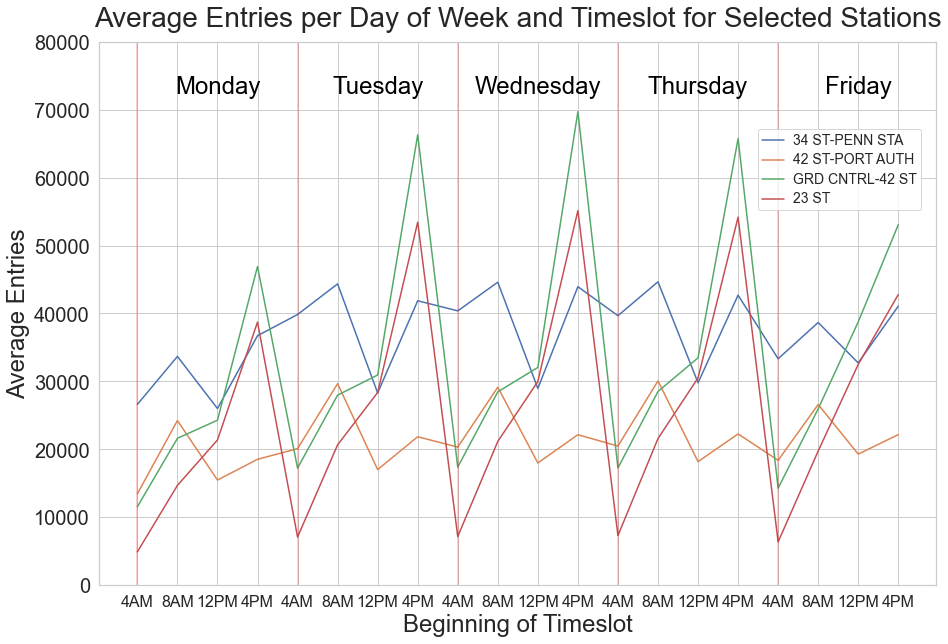

In [29]:
top_stations_all = ["34 ST-PENN STA", "42 ST-PORT AUTH", "GRD CNTRL-42 ST", "23 ST"]
top_stations_by_dow_time_mean = stations_by_dow_time_mean.loc[top_stations_all].reset_index()

sns.set_style("whitegrid")
ax = sns.lineplot(data=top_stations_by_dow_time_mean, x="DOW_TIME", y="NUM_ENTRIES", hue="STATION");

ax.set_title("Average Entries per Day of Week and Timeslot for Selected Stations", fontsize=28, pad=15)
ax.set_xlabel("Beginning of Timeslot", fontsize = 24)
ax.set_ylabel("Average Entries", fontsize=24)

# Label the x-ticks with the corresponding times; we will label the day of the week on the plot itself
ax.set_xticks(np.linspace(0, 4.75, 20))
ax.set_xticklabels(np.array([["4AM", "8AM", "12PM", "4PM"] * 5]).flatten(), fontsize=16);

ax.yaxis.set_ticks(np.arange(0, 80000+1, 10000))
ax.set_yticklabels(ax.get_yticks(), fontsize=20)
ax.set(ylim=(0, 80000));

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

# Draw vertical lines on plot to separate different weekdays and label each resultant column
for i in range(5):
    ax.axvline(i, 0, 10, alpha=0.25, color="red")
    ax.text(0.5 + i, 75000, weekdays[i], va="top", ha="center", size='medium', fontsize="24", color='black')

plt.legend(bbox_to_anchor=(0.78, 0.85))
plt.setp(ax.get_legend().get_texts(), fontsize='14');

We note that the "morning" stations and "afternoon" stations in fact exhibit different trends over the day, generally peaking in the morning and afternoon respectively, with additional small variations based on day of the week.

## Recommendation Algorithm

Our recommendation algorithm assumes the availability of a fixed amount of resources: a number of teams available for each day of week and timeslot. We apply a linear sum assignment matching algorithm for any given timeslot; for each timeslot, the teams available at that timeslot over the week are each assigned to a unique station in order to maximize the number of people encountered. We require uniqueness within each timeslot so we avoid revisiting any station at the same timeslot during the week, which could lead to encountering the same people again. This is a well-known linear programming question with a polynomial time solution and can be solved using `scipy.optimize.linear_sum_assignment`.

For example, for the 8AM timeslot, we might have 2 teams available on Monday, 3 on Tuesday, 1 on Wednesday, 2 on Thursday, and 1 on Friday. Our algorithm would assign those teams to 9 unique stations, using our data for station traffic for particular times on particular days of the week in order to maximize the expected exposure.

In [30]:
# The relevant DataFrame
stations_by_dow_time_mean.head(8)

STATION  DOW_TIME  DOW_INDEX  TIME    
1 AV     0.00      0          04:00:00    1072.666667
         0.25      0          08:00:00    3589.666667
         0.50      0          12:00:00    3463.333333
         0.75      0          16:00:00    4905.666667
         1.00      1          04:00:00    1619.000000
         1.25      1          08:00:00    4751.666667
         1.50      1          12:00:00    4159.333333
         1.75      1          16:00:00    6422.333333
Name: NUM_ENTRIES, dtype: float64

### Algorithm Code

In [31]:
from scipy.optimize import linear_sum_assignment

def assign_teams(time_of_day, teams_per_day):
    """
        teams is a list of day indices, e.g. [0, 0, 1, 2, 3] indicating 2 teams available
        Monday at that time, one on Tuesday, one on Wednesday, one on Thursday
        
        time_of_day is 4AM, 8AM, 12PM, or 4PM, rendered as %H:00:00
        
        returns cost, match where match is a list of stations (no overlap)
    """
    # Grab the data for only this timeslot, then group by day of week and station
    timeslot_filter = stations_by_dow_time_mean.loc[:,:,:,time_of_day].groupby(['DOW_INDEX', 'STATION']).first()
    station_list = list(timeslot_filter[0].index)
    
    # Build up an array of traffic counts
    traffic_array = []
    
    # Grab the data indicating traffic counts for each station on a particular day of the week, then
    # add that row to traffic_array once for each team available on that day
    
    # For Monday to Friday...
    for dow_index in range(5):
        num_teams = teams_per_day[dow_index]
        # Append the traffic count array for that day to our traffic array num_teams times
        for team in range(num_teams):
            traffic_array.append(timeslot_filter[dow_index].tolist())
    
    # Multiply by -1 as linear_sum_assignment is a minimizer
    traffic_array = -np.array(traffic_array)
    
    # Run our actual linear program
    teams, station_indices = linear_sum_assignment(traffic_array)
   
    # Total traffic for our recommended assignment
    traffic_total = -sum(traffic_array[teams, station_indices])
    

    traffic_individual = []
    station_idx_assignments = []
    station_names = []
    
    # We need to return our results in an interpretable way. For each day of the week,
    # get lists of the station names, station indices, and traffic counts. Appending
    # these lists will yield arrays of length 5, containing a list for each day of
    # the week
    
    # Because of the way teams_per_day is formatted, we grab the indices of the teams
    # assigned to any particular day by keeping track of how many teams have been
    # assigned already
    team_index = 0
    for dow_index in range(5):
        team_index_range = range(team_index, team_index + teams_per_day[dow_index])
       
        day_traffic_counts = -traffic_array[team_index_range, station_indices[team_index_range]]
        day_station_indices = station_indices[team_index:team_index+teams_per_day[dow_index]]
        day_stations = [station_list[idx] for idx in day_station_indices]
        
        traffic_individual.append(day_traffic_counts)
        station_idx_assignments.append(day_station_indices)
        station_names.append(day_stations)
        team_index += teams_per_day[dow_index]
        
    return traffic_total, station_names, station_idx_assignments, traffic_individual

### Recommended Assignments for Fixed Team Configurations
Let's see what our algorithm recommends for a few team compositions.

In [32]:
# One team per day, 8AM-12PM every day
traffic, assignment, _, _ = assign_teams("08:00:00", [1,1,1,1,1])
traffic, assignment

(149409.33333333334,
 [['42 ST-PORT AUTH'],
  ['34 ST-PENN STA'],
  ['86 ST'],
  ['GRD CNTRL-42 ST'],
  ['34 ST-HERALD SQ']])

In [33]:
# Two teams per day, 8AM-12PM every day
traffic, assignment, _, _ = assign_teams("08:00:00", [2,2,2,2,2])
traffic, assignment

(241832.33333333334,
 [['FLUSHING-MAIN', '96 ST'],
  ['34 ST-PENN STA', '34 ST-HERALD SQ'],
  ['86 ST', 'GRD CNTRL-42 ST'],
  ['42 ST-PORT AUTH', '23 ST'],
  ['14 ST-UNION SQ', '125 ST']])

In [34]:
# One team per day, 4PM-8PM every day, except an extra team is
# available on Friday
traffic, assignment, _, _ = assign_teams("08:00:00", [1,1,1,1,2])
traffic, assignment

(169169.0,
 [['42 ST-PORT AUTH'],
  ['34 ST-PENN STA'],
  ['86 ST'],
  ['GRD CNTRL-42 ST'],
  ['23 ST', '34 ST-HERALD SQ']])

### Comparison of Different Team Configurations

Aside from simply giving a recommendation based on a list of teams and availabilities, our algorithm also has the flexibility to recommend different team configurations, as well as different numbers of teams.

For instance, if we could send team out every day at 4AM, 8AM, 12PM, and 4PM; or we could send two teams out every day at 8AM and 12PM. These configurations involve the same "people-hours" of work, but let's see how they fare in terms of performance.

In [35]:
traffic_counts = []
timeslot_assignments = []
for time in ["04:00:00", "08:00:00", "12:00:00", "16:00:00"]:
    traffic, assignment, _, _ = assign_teams(time, [1,1,1,1,1])
    traffic_counts.append(traffic)
    timeslot_assignments.append(assignment)
# timeslot_assignments[0] indicates the assignments for 4AM, [1] is 8AM, etc.
sum(traffic_counts), timeslot_assignments

(655915.3333333334,
 [[['GRD CNTRL-42 ST'],
   ['42 ST-PORT AUTH'],
   ['34 ST-PENN STA'],
   ['96 ST'],
   ['125 ST']],
  [['42 ST-PORT AUTH'],
   ['34 ST-PENN STA'],
   ['86 ST'],
   ['GRD CNTRL-42 ST'],
   ['34 ST-HERALD SQ']],
  [['34 ST-PENN STA'],
   ['14 ST-UNION SQ'],
   ['23 ST'],
   ['FULTON ST'],
   ['GRD CNTRL-42 ST']],
  [['34 ST-PENN STA'],
   ['TIMES SQ-42 ST'],
   ['GRD CNTRL-42 ST'],
   ['23 ST'],
   ['34 ST-HERALD SQ']]])

In [36]:
traffic_counts = []
timeslot_assignments = []
for time in ["08:00:00", "12:00:00"]:
    traffic, assignment, _, _ = assign_teams(time, [2,2,2,2,2])
    traffic_counts.append(traffic)
    timeslot_assignments.append(assignment)
sum(traffic_counts), timeslot_assignments

(504869.66666666674,
 [[['FLUSHING-MAIN', '96 ST'],
   ['34 ST-PENN STA', '34 ST-HERALD SQ'],
   ['86 ST', 'GRD CNTRL-42 ST'],
   ['42 ST-PORT AUTH', '23 ST'],
   ['14 ST-UNION SQ', '125 ST']],
  [['42 ST-PORT AUTH', '125 ST'],
   ['CANAL ST', '14 ST-UNION SQ'],
   ['86 ST', '34 ST-HERALD SQ'],
   ['FULTON ST', '23 ST'],
   ['GRD CNTRL-42 ST', '34 ST-PENN STA']]])

So sending 1 team out from 4AM-8PM daily gives ~650k encounters, whereas sending 2 teams out from 8AM-12PM daily gives ~505k encounters. We see that the first approach performs significantly better.

### Optimizing Amount of Committed Resources

Now let's consider _how many_ teams to send out. Suppose we send out _x_ teams every day from 8AM-12PM. We will of course encounter more traffic as _x_ increases, but because we do not want to revisit any station at the same timeslot on multiple days, we will eventually resort to sending our additional teams to lower and lower traffic stations. We would expect to see diminishing marginal returns here.

In [37]:
traffic_counts = [0]

for teams in range(1, 10):
    individual_count = 0
    for time in ["04:00:00", "08:00:00", "12:00:00", "16:00:00"]:
        time_count, _, _, _ = assign_teams(time, [teams, teams, teams, teams, teams])
        individual_count += time_count
    traffic_counts.append(individual_count)

traffic_counts

[0,
 655915.3333333334,
 1084431.6666666665,
 1433320.0,
 1710815.3333333335,
 1952994.0,
 2163261.3333333335,
 2343577.0,
 2505952.0,
 2653251.3333333335]

It looks like diminishing returns do in fact occur. Let's plot and see:

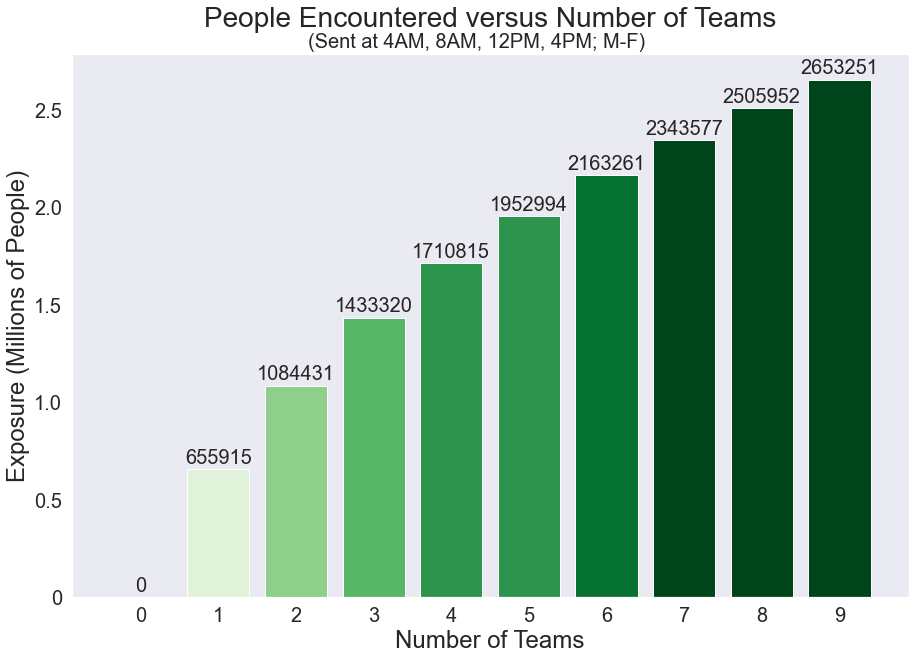

In [38]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

sns.set_style("dark")

plt.title("People Encountered versus Number of Teams", fontsize=28, pad=27)
plt.suptitle("(Sent at 4AM, 8AM, 12PM, 4PM; M-F)", fontsize=20, x=0.5, y=0.91)
plt.xlabel("Number of Teams", fontsize=24)
plt.ylabel("Exposure (Millions of People)", fontsize=24)
viridis = cm.get_cmap('Greens', 8)
plt.xticks([0,1,2,3,4,5,6,7,8,9], fontsize=20)
plt.yticks([0, 500000, 1000000, 1500000, 2000000, 2500000], labels=[0, 0.5, 1.0, 1.5, 2.0, 2.5], fontsize=20)

# Plot each bar separately as we want to shade each according to its value
the_plt = plt.bar([i for i in range(0,10)], traffic_counts, color=[viridis(num/traffic_counts[-1]) for num in traffic_counts])

patches = the_plt.patches
ax = plt.gca()
for i in range(len(patches)):
    rect = patches[i]
    ax.annotate(int(traffic_counts[i]), (rect.get_x() + rect.get_width()/2, rect.get_height()+30000), ha="center", fontsize=20)

So we see a clear trend of diminishing returns. Just by eyeballing the chart, it looks like 4 teams per day hits a sweet spot at 1.71 million exposures, with further teams experiencing drastic falloffs in marginal utility. Given the option to choose between sending 1-10 teams out, then, we might recommend the following:

In [39]:
traffic_counts = []
timeslot_assignments = []
for time in ["04:00:00", "08:00:00", "12:00:00", "16:00:00"]:
    traffic, assignment, _, _ = assign_teams(time, [4,4,4,4,4])
    traffic_counts.append(traffic)
    timeslot_assignments.append(assignment)
# timeslot_assignments[0] indicates the assignments for 4AM, [1] is 8AM, etc.
sum(traffic_counts), timeslot_assignments

(1710815.3333333335,
 [[['77 ST', '14 ST-UNION SQ', 'FLATBUSH AV-B.C', '103 ST'],
   ['FULTON ST', 'GRD CNTRL-42 ST', 'JAMAICA 179 ST', 'FOREST HILLS 71'],
   ['34 ST-PENN STA', '125 ST', '86 ST', 'JAMAICA CENTER'],
   ['96 ST', '116 ST', 'FLUSHING-MAIN', '42 ST-PORT AUTH'],
   ['CHURCH AV', 'JKSN HT-ROOSVLT', 'WOODHAVEN BLVD', 'BAY PKWY']],
  [['CHURCH AV', '59 ST COLUMBUS', '145 ST', 'TIMES SQ-42 ST'],
   ['ATL AV-BARCLAY', 'JAMAICA CENTER', '34 ST-HERALD SQ', '34 ST-PENN STA'],
   ['GRD CNTRL-42 ST', 'FLUSHING-MAIN', '86 ST', '59 ST'],
   ['23 ST', '96 ST', '42 ST-PORT AUTH', 'JKSN HT-ROOSVLT'],
   ['14 ST-UNION SQ', 'FULTON ST', '28 ST', '125 ST']],
  [['FLUSHING-MAIN', '42 ST-PORT AUTH', '59 ST', '72 ST'],
   ['96 ST', '28 ST', 'CANAL ST', 'WALL ST'],
   ['34 ST-HERALD SQ', '125 ST', '59 ST COLUMBUS', '14 ST-UNION SQ'],
   ['14 ST', 'CHAMBERS ST', 'FULTON ST', '86 ST'],
   ['GRD CNTRL-42 ST', 'TIMES SQ-42 ST', '34 ST-PENN STA', '23 ST']],
  [['14 ST', 'WALL ST', '42 ST-PORT AUTH',

## Further Work

We have various ideas for future work on this project. One simple yet potentially very effective modification would be to allow for weighting of different stations based on demographic data. For instance, high-income areas with many technology companies and a population with a history of charitable giving might be weighted higher. A drawback here is that the "score" of each assignment would no longer be interpretable as "number of people encountered" but would rather only have meaning in comparison to other assignments and configurations. We could even incorporate both entry and exit data, and weight based on the assumption that people in the morning, people enter stations near their homes and exit stations near their workplaces, while in the afternoon people enter stations near their workplacs and exit stations near their homes.

Another potential extension would be to allow repeated visits to stations, but discount them to some degree. It might be more fruitful to visit Grand Central Station twice in one week rather than visit a new obscure station the second time, for example. Our algorithm would require revision to implement this feature, however. We could perhaps extend the traffic array in `assign_teams` to have five entries per station indicating the first-fifth visit to a station that week. Each subsequent entry would be discounted by some factor to reflect the diminishing returns of visiting a station multiple times. However, in this case our approach would yield an assignment where multiple teams on the same day attempt to visit a station the "first" time _and_ the "second" time on the same day. We would need to do more research to determine whether this issue can be resolved, or whether it invalidates the linear assignment approach entirely.